In this notebook we will conduct regression analysis of investments in Kazakhstan.

In [ ]:
import math
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression as MarkovAR
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from sklearn.linear_model import LinearRegression as sklr
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler

C:\Users\AERC\AppData\Local\Temp/ipykernel_10708/3769017627.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.inv_tot[i] = df_new.inv_tot[i+4]-(df_new.inv_growth[i+4]-np.log(100))


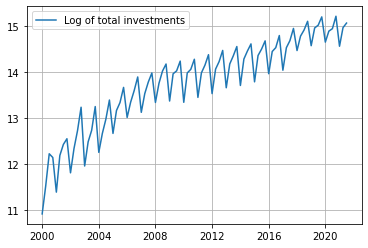

In [ ]:
data = pd.read_excel('регрессоры_ПИФ_04.07.22.xlsx',header=1)
inv_growth = pd.read_excel('inv_growth_4.xlsx',header=1)

data=data.rename(columns={'Unnamed: 0':'date','Inv_tot':'inv_tot','Unnamed: 4':'inv_growth'})
data.date=pd.to_datetime(data.date)
data['inv_growth']=inv_growth['Inv_tot']

df_new = data[['date',
               'inv_tot',
               'inv_growth',
               'GDP_kz_real_KZT',
               'realGDP_growth__KZT',
               'oil_price',
               'oil_prod',
               'usd_kzt',
               'rub_kzt',
               'rub_kzt_growth',
               'cpi_kz']].copy()
df_new['date'] = df_new.index
df_new['inv_growth']=df_new['inv_growth'].map(np.log)
df_new['inv_tot'] = df_new['inv_tot'].map(np.log)
df_new['GDP_kz_real_KZT'] = df_new['GDP_kz_real_KZT'].map(np.log)
df_new['realGDP_growth__KZT'] = df_new['realGDP_growth__KZT'].map(lambda x: np.log(100+x))
df_new=df_new.rename(columns={'GDP_kz_real_KZT':'gdp','realGDP_growth__KZT':'gdp_growth'})
#print(df_new.drop('inv_tot',axis='columns').dropna().index)

na = df_new.inv_tot.isna().to_list()
last_na = na.index(False)-1
i = last_na
while i>=0:
    df_new.inv_tot[i] = df_new.inv_tot[i+4]-(df_new.inv_growth[i+4]-np.log(100))
    i-=1

plt.plot(data.date.values,df_new.inv_tot.values,label='Log of total investments')
plt.legend()
plt.grid(True)

Heat map of correlation for quick visual overview. First we will try to analyse the total investments (inv_tot)

<AxesSubplot:>

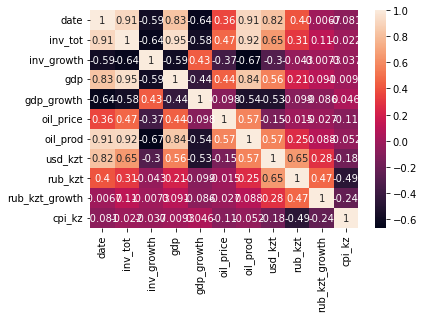

In [ ]:
import seaborn as sns
sns.heatmap(df_new.corr(),annot=True)

In [ ]:
X_new = df_new.dropna()[['gdp','gdp_growth','usd_kzt','oil_prod','oil_price']]
scaler = StandardScaler()
X_scaled  = scaler.fit_transform(X=X_new)
y = df_new.dropna()['inv_tot']
model = MarkovRegression(endog=y,exog=X_scaled,
                         k_regimes=2,
                         trend='ct',
                         switching_trend=True,
                         switching_exog=True,
                         switching_variance=False)
res = model.fit()
res.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


LinAlgError: SVD did not converge

Markov regression optimization algorithm failed to converge. We will try OLS

score 0.956664844400905
RMSE 0.180357958167109


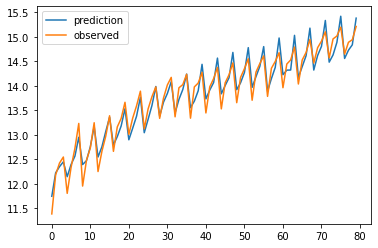

In [ ]:
from sklearn.linear_model import LinearRegression as sklr
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split

sc1 = StandardScaler()
sc2 = StandardScaler()
X_sc2  = sc2.fit_transform(X_new)
y_sc1 = sc1.fit_transform(y.values.reshape(-1,1))

model1 = sklr(fit_intercept=True).fit(X_sc2,y_sc1)
model2 = Lasso(fit_intercept=True).fit(X_sc2,y_sc1)
model1_pred = sc1.inverse_transform(model1.predict(X_sc2)).transpose()[0]
plt.plot(model1_pred,label='prediction')
plt.plot(y.to_numpy(),label='observed')
plt.legend()
print('score',model1.score(X_sc2,y_sc1))
print('RMSE',MSE(sc1.inverse_transform(model1.predict(X_sc2)),y.to_numpy(),squared=False))

optimal alpha: 7.346938775510204
-0.4354300157843276
RMSE on test 0.3982546130353897


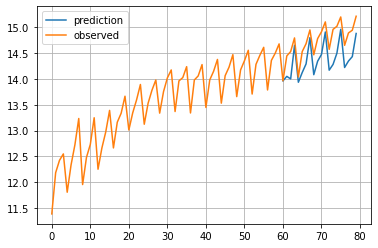

In [ ]:
train_size=0.75
X_train, X_test, y_train, y_test = train_test_split(X_sc2, y, shuffle=False,train_size=train_size)
model1 = Ridge(fit_intercept=True)

loss_list = []
grid = np.linspace(0,10,num=50)
for alp in grid:
    model1.set_params(alpha=alp)
    model1.fit(X=X_train,y=y_train)
    y_pred_test = model1.predict(X_test)
    loss_list.append(MSE(y_pred_test,y_test,squared=False))

optimal_alpha = grid[loss_list.index(min(loss_list))]
model1.set_params(alpha=optimal_alpha)
print('optimal alpha:',optimal_alpha)
print(model1.score(X=X_test,y=y_test))

y_pred_test=model1.predict(X_test)
fig,ax=plt.subplots()
ax.plot(range(int(len(y)*train_size),len(y)),y_pred_test,label='prediction')
ax.plot(y.to_numpy(),label='observed')
ax.legend()
ax.grid(True)
print('RMSE on test',MSE(y_pred_test,y_test,squared=False))

We will train least squares with ridge regularization with parameter alpha manimizing MSE on test sample.
It is important that we predict for the next quarter only, then append this observation to the train sample and refit the model. This way the model is fit and predicts observation-by-observation wit initial train size = 0.75

optimal alpha: 6.73469387755102
RMSE on test: 0.21270697120102408
intercept: 13.824100732476099 
coefficients: [ 0.43776566 -0.0959348   0.14761004  0.22623082  0.08414018]


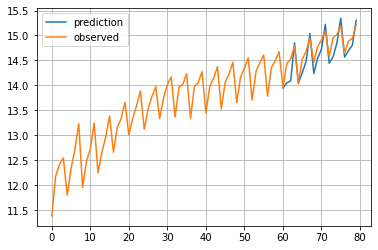

In [ ]:
initial_train_size=0.75
n = len(y)

model1 = Ridge(fit_intercept=True)
score_list = []
grid = np.linspace(0,10,num=50)
for alp in grid:
    model1.set_params(alpha=alp)
    y_pred_test = []
    for train_size in np.linspace(initial_train_size,1,num=int(n*(1-initial_train_size))+1)[:-1]:
        X_train, X_test, y_train, y_test = train_test_split(X_sc2, y, shuffle=False,train_size=train_size)
        model1.fit(X=X_train,y=y_train)
        y_pred_test.append(model1.predict([X_test[0]])[0])
    score_list.append(MSE(y_pred_test,y[int(n*initial_train_size):],squared=False))

optimal_alpha = grid[score_list.index(min(score_list))]
print('optimal alpha:',optimal_alpha)
model1.set_params(alpha=optimal_alpha)
y_pred_test = []
for train_size in np.linspace(initial_train_size,1,num=int(n*(1-initial_train_size))+1)[:-1]:
    X_train, X_test, y_train, y_test = train_test_split(X_sc2, y, shuffle=False,train_size=train_size)
    model1.fit(X=X_train,y=y_train)
    y_pred_test.append(model1.predict([X_test[0]])[0])
    
fig,ax=plt.subplots()
ax.plot(range(int(len(y)*initial_train_size),len(y)),y_pred_test,label='prediction')
ax.plot(y.to_numpy(),label='observed')
ax.legend()
ax.grid(True)
print('RMSE on test:',MSE(y_pred_test,y[int(n*initial_train_size):],squared=False))
print('intercept:',model1.intercept_,'\ncoefficients:',model1.coef_)

Lets do some preprocessing of the data to make it more stationary. We can see obvious trend and seasonal patterns in the series. We'll get rid of them by considering relative growth by year (from a quarter of last year to the same quarter of current year)

In [ ]:
df1 = df_new[['inv_growth','date','gdp','gdp_growth','usd_kzt','oil_prod','oil_price']].dropna()
X1 = df1.drop(columns=['inv_growth'])
scaler = StandardScaler()
X_scaled  = scaler.fit_transform(X=X1)
y1 = df1['inv_growth']
model = MarkovAR(endog=y,exog=X_scaled,
                         order=1,
                         k_regimes=2,
                         trend='ct',
                         switching_trend=True,
                         switching_exog=True,
                         switching_variance=False)
res = model.fit()
res.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


LinAlgError: SVD did not converge

This time Markov regression did not detect second regime as well, so we reject this model

score 0.35719521493115935
RMSE 0.11853430809367312
RMSE for total values 0.22970666783229132


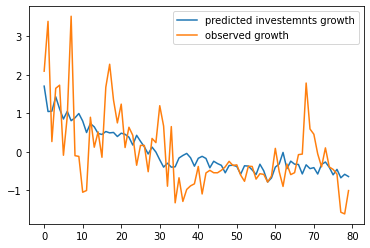

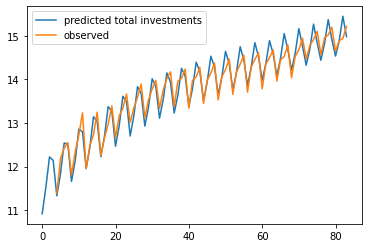

In [ ]:
sc1 = StandardScaler()
sc2 = StandardScaler()
X_sc  = sc2.fit_transform(X=X1)
y_sc = sc1.fit_transform(y1.values.reshape(-1,1))

model3 = Ridge(fit_intercept=True,alpha=optimal_alpha).fit(X_sc,y_sc)
fig,ax=plt.subplots()
ax.plot(model3.predict(X_sc),label='predicted investemnts growth')
ax.plot(y_sc1,label='observed growth')
ax.legend()
print('score',model3.score(X_sc,y_sc))
model3_pred = sc1.inverse_transform(model3.predict(X_sc).reshape(1,-1)[0])
print('RMSE',MSE(sc1.inverse_transform(model3.predict(X_sc)),y1,squared=False))

y_pred1[:4] = df_new.inv_tot.values[:4]
for i in y.index:
    y_pred1[i] = model3_pred[i-4]-np.log(100)+y_pred1[i-4]
fig1,ax1=plt.subplots()
ax1.plot(y_pred1,label='predicted total investments')
ax1.plot(y,label='observed')
ax1.legend()
print('RMSE for total values',MSE(y_pred1[4:],y,squared=False))

p-value of Breusch-Pagan test 0.013514884652822298


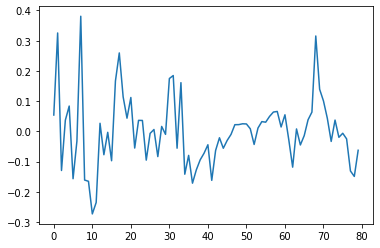

In [ ]:
bp_test = sm.stats.diagnostic.het_breuschpagan
resid3 = y1.values-model3_pred

plt.plot(resid3)
print('p-value of Breusch-Pagan test',bp_test(resid3,exog_het=np.array(range(n)).reshape(-1,1))[3])

Breusch-Pagan test rejects homoscedasticity hypothesis. Therefore we will use Generalised Least Squares

In [ ]:
#sm.graphics.tsa.plot_pacf(resid3)
#sm.graphics.tsa.plot_acf(resid3)

We will assume that the residuals are independent, but have different variances depending on time. We'll use an approximation of variance trend by HP filter applied on residuals squares as the estimator of this dependence

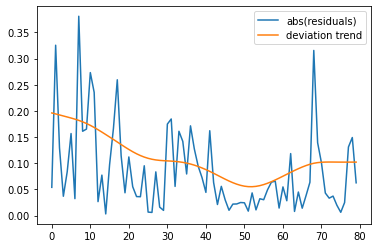

In [ ]:
plt.plot(abs(resid3),label='abs(residuals)')
cycle, sigma2_trend = sm.tsa.filters.hpfilter(resid3**2,lamb=1600)
trend_mean = np.zeros(n)
#for k in range(100):
#    eps = scipy.stats.norm.rvs(0,1,size=n)*sigma2_trend**(1/2)
#    cycle1, sigma2_trend1 = sm.tsa.filters.hpfilter((eps)**2,lamb=1600)
#    trend_mean+=sigma2_trend1/100
#plt.plot(abs(eps),label='eps')
#plt.plot(trend_mean**(1/2),label='eps trend mean')
plt.plot(sigma2_trend**(1/2),label='deviation trend')
plt.legend()

                                 GLS Regression Results                                
Dep. Variable:             inv_growth   R-squared (uncentered):                   1.000
Model:                            GLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          3.171e+04
Date:                Mon, 25 Jul 2022   Prob (F-statistic):                   2.01e-124
Time:                        14:06:47   Log-Likelihood:                          73.538
No. Observations:                  80   AIC:                                     -133.1
Df Residuals:                      73   BIC:                                     -116.4
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

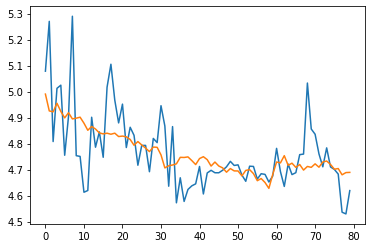

In [ ]:
X_inter = np.array([np.append(1,X_sc[i]) for i in range(n)])
gls_model = sm.GLS(endog=y1,exog=X_inter,sigma=sigma2_trend,hasconst=False)
gls_res = gls_model.fit()
print(gls_res.summary())
plt.plot(y1.to_numpy())
plt.plot(gls_model.predict(params=gls_res.params,exog=X_inter))
print('RMSE',MSE(gls_model.predict(params=gls_res.params,exog=X_inter),y1,squared=False))

RMSE 0.22763883680584932


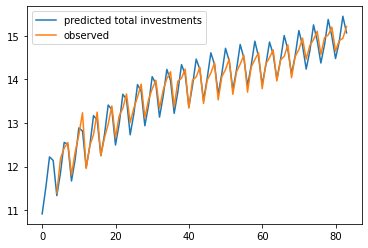

In [ ]:
gls_pred = gls_model.predict(params=gls_res.params,exog=X_inter)
y_pred1 = np.zeros(y.index[-1]+1)
y_pred1[:4] = df_new.inv_tot.values[:4]
for i in y.index:
    y_pred1[i] = model3_pred[i-4]-np.log(100)+y_pred1[i-4]
#y_pred1 = pd.Series()
plt.plot(y_pred1,label='predicted total investments')
plt.plot(y,label='observed')
plt.legend()
print('RMSE',MSE(y_pred1[4:],y,squared=False))